In [1]:
# Membuat pengecekan tensorflow
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

assert LooseVersion(tf.__version__) >= LooseVersion('1.0')
print("TensorFlow Version: {}".format(tf.__version__))

if not tf.test.gpu_device_name():
    warnings.warn("No GPU Found: Please ensure you have installed TensorFlow corrently")
else:
    print("Default GPU Device: {}".format(tf.test.gpu_device_name()))

TensorFlow Version: 2.6.0
Default GPU Device: /device:GPU:0


C:\Users\Rzl\AppData\Local\Temp\ipykernel_18128\3749508200.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  assert LooseVersion(tf.__version__) >= LooseVersion('1.0')


# Import Libraries

In [2]:
# Arsitektur CNN
from tensorflow.keras import layers, models, callbacks

# Generator dan Praproses Data
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Fungsi Loss
from tensorflow.keras.metrics import sparse_categorical_crossentropy

# Visualisasi
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

# Pengaturan Direktori
import os

# Log
import pandas as pd

import h5py

ImportError: DLL load failed while importing _errors: The specified procedure could not be found.

# Pra-pelatihan

In [43]:
# Membuat nama kelas berdasarkan urutan folder
class_names = [ 'ain', 'alif', 'ba', 'dal', 'dhod', 'dzal',
                'dzho', 'fa', 'ghoin', 'ha', 'ha\'', 'hamzah', 'jim',
                'kaf', 'kho', 'lam', 'lamalif', 'mim', 'nun', 'qof',
                'ro', 'shod', 'sin', 'syin', 'ta', 'tho', 'tsa', 
                'wawu', 'ya', 'zaiAinn']

## Arsitektur CNN

![arsitektur](arsitektur_baru.png)

In [4]:
# Membuat arsitektur CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='valid', activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2), padding='valid'))
model.add(layers.Conv2D(64, (3, 3), padding='valid', activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2), padding='valid'))
model.add(layers.Conv2D(128, (3, 3), padding='valid', activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2), padding='valid'))
model.add(layers.Conv2D(256, (3, 3), padding='valid', activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2), padding='valid'))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(30, activation='softmax'))

# Melihat detail arsitektur
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

## Dataset | Praproses dan Augmentasi

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


The image is binary.


(150, 150, 3)

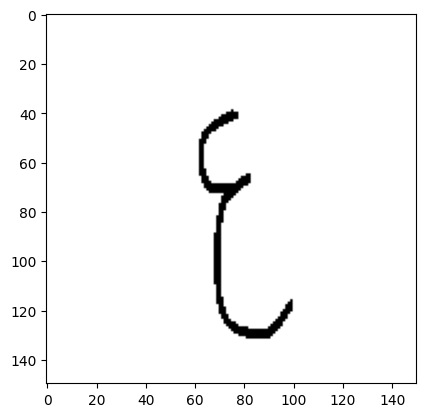

In [30]:
import cv2
from PIL import Image,ImageChops

def normalize(I):
    mn=I.min()
    mx=I.max()
    mx-=mn
    I=((I-mn)/mx)*255
    return I.astype(np.uint8)

def trim(image):
    #image=Image.fromarray((image* 255).astype(np.uint8))
    image = normalize(image)
    image=Image.fromarray(image)
    bg = Image.new(image.mode, image.size, image.getpixel((0,0))) # black background
    diff = ImageChops.difference(image, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return np.array(image.crop(bbox))
# cv2.INTER_AREA: examiner les pixels voisins et utiliser ces voisins pour augmenter ou diminuer optiquement la taille de l’image sans introduire de distorsions
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        #r = width / float(w)
        #dim = (width, int(h * r))
        dim = (width,height)
    resized = cv2.resize(image, dim, interpolation = inter)
    return resized
    
def cleaned_image(image):
    bg=np.ones((150,150))
    bg = bg*255
    #image=trim(image)
    image = normalize(image)
    image=np.array(image)
    image=image_resize(image,height=150)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh, image_binary = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    hh, ww = bg.shape
    h, w = image_binary.shape
    yoff = round((hh-h)/2)
    xoff = round((ww-w)/2)
    if xoff<=0:
        image=image_resize(image,height=150,width=150)
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        thresh, image_binary = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        h, w = image_binary.shape
        yoff = round((hh-h)/2)
        xoff = round((ww-w)/2)
    result = bg.copy()
    result[yoff:yoff+h, xoff:xoff+w] = image_binary
    result = np.stack((result,)*3, axis=-1)
    #result = np.expand_dims(result,axis=2)
    return result

def check_binary(image):
    unique_values = np.unique(image)
    # Check if the image is binary (only two unique values, like 0 and 255)
    if len(unique_values) == 2 and (0 in unique_values) and (255 in unique_values):
        print("The image is binary.")
    else:
        print("The image is not binary.")

image= cv2.imread(r"C:\Users\Rzl\Documents\tugas s2\Hijaiyah-Deployment-CNN\dataset\train\ain\aien_0.jpg")
image = cleaned_image(image)
image = np.array(image)
check_binary(image)
plt.imshow(image)
image.shape

In [31]:
# Pengaturan direktori
import cv2
PATH = 'dataset'
VAL_DATA = 'test_mixed'
TOTAL_TRAIN_DATA=1680
TRAIN_DIR = os.path.join(PATH, 'train')
VALIDATION_DIR = os.path.join(PATH, VAL_DATA)

BATCH_SIZE = 56
IMG_SIZE = (150, 150)

# Membuat generator pelatihan
'''
train_datagen = ImageDataGenerator( 
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      shear_range=0.2,;
      height_shift_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'

)
'''

train_datagen = ImageDataGenerator(
    #rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode='nearest',
    preprocessing_function=cleaned_image
)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='sparse',
                                                    target_size=IMG_SIZE,
                                                    color_mode='rgb'
                                                   )

validation_datagen = ImageDataGenerator( 
    preprocessing_function=cleaned_image
)

# Membuat generator validasi
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='sparse',
                                                    target_size=IMG_SIZE,
                                                    color_mode='rgb'
                                                    )
def plot_augmented_images(generator, num_images=5):
    """Plot several augmented images."""
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        # Ambil batch gambar augmented dari generator
        augmented_images, labels = generator.next()  # Batch dari generator
        
        # Pilih gambar pertama dari batch
        image = augmented_images[0]

        # Convert grayscale to RGB if necessary
        '''
        if image.shape[-1] == 1:  # Check if the image is single-channel (grayscale)
            image = np.repeat(image, 3, axis=-1)
        '''
        
        # Rescale image to range [0, 255] for displaying
        image = np.clip(image * 255, 0, 255).astype(np.uint8)
        
        # Tampilkan gambar
        axes[i].imshow(image)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


Found 1680 images belonging to 30 classes.
Found 420 images belonging to 30 classes.


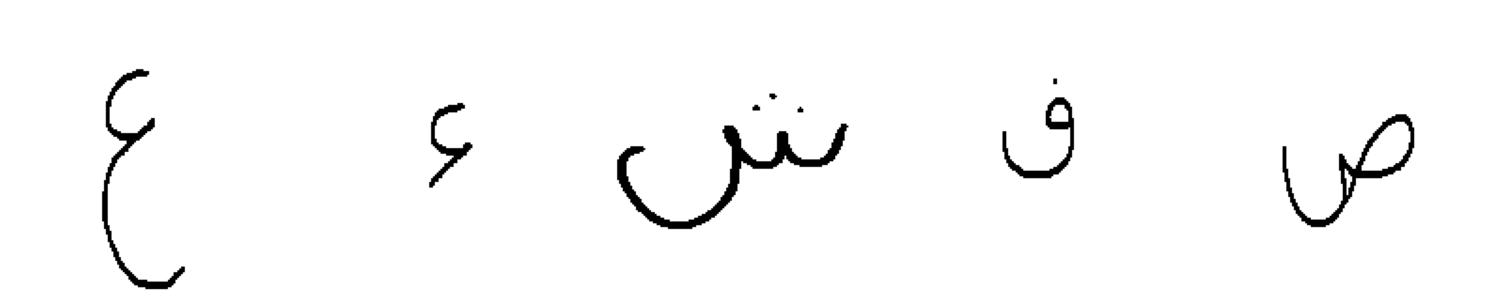

In [37]:
plot_augmented_images(train_generator, num_images=5)

In [94]:
augmented_images, labels = train_generator.next()

## Pelatihan

In [38]:
# Callback untuk menyimpan model setiap epoch
model_save_callback = callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}_{accuracy:.3f}.h5', save_best_only=False, save_weights_only=False, monitor='val_accuracy')

# Inisialisasi metrik
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Pelatihan!
history = model.fit( train_generator,
                     steps_per_epoch=train_generator.n // train_generator.batch_size,
                     epochs=105, 
                     validation_data=validation_generator,
                     validation_steps= validation_generator.n // validation_generator.batch_size,
                     callbacks=[
                         model_save_callback
                     ]
                   ) 

Epoch 1/105
30/30 [==============================] - 3s 86ms/step - loss: 3.2484 - accuracy: 0.2685 - val_loss: 1.7749 - val_accuracy: 0.4643
Epoch 2/105
30/30 [==============================] - 2s 78ms/step - loss: 1.2170 - accuracy: 0.5887 - val_loss: 1.0929 - val_accuracy: 0.6480
Epoch 3/105
30/30 [==============================] - 2s 79ms/step - loss: 0.7505 - accuracy: 0.7310 - val_loss: 0.9587 - val_accuracy: 0.7168
Epoch 4/105
30/30 [==============================] - 2s 78ms/step - loss: 0.4977 - accuracy: 0.8143 - val_loss: 0.7449 - val_accuracy: 0.7730
Epoch 5/105
30/30 [==============================] - 2s 78ms/step - loss: 0.3039 - accuracy: 0.8887 - val_loss: 0.7931 - val_accuracy: 0.7908
Epoch 6/105
30/30 [==============================] - 2s 78ms/step - loss: 0.1972 - accuracy: 0.9292 - val_loss: 0.7862 - val_accuracy: 0.8112
Epoch 7/105
30/30 [==============================] - 2s 79ms/step - loss: 0.1486 - accuracy: 0.9488 - val_loss: 0.8166 - val_accuracy: 0.8214
Epoch 

## Visualisasi metrik

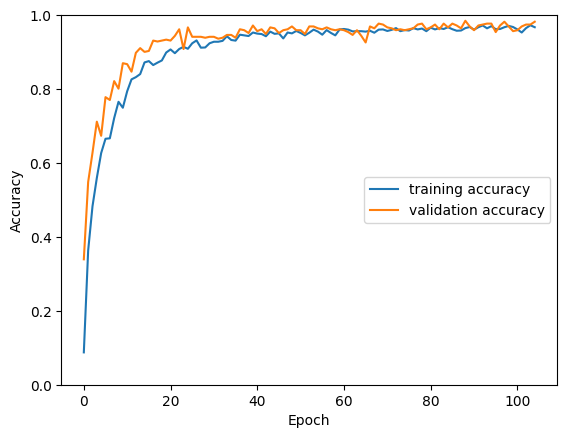

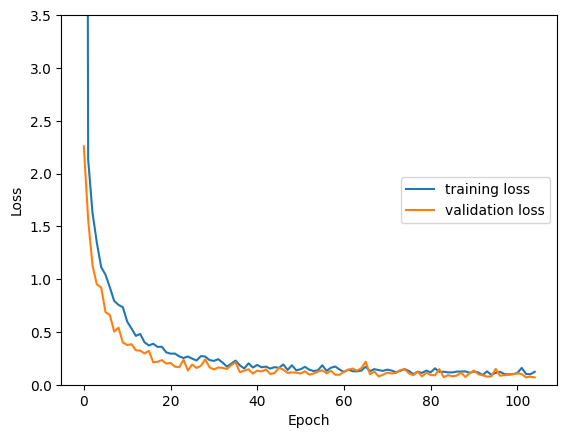

In [83]:
# Menyimpan history pelatihan
pd.DataFrame(history.history).to_csv('history.csv')

# Memvisualisasikan metrik akurasi selama pelatihan 
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0., 1]) 
plt.legend(loc='right')
plt.savefig('train_val_acc_augmentation.png')
plt.show()

# Memvisualisasikan metrik loss selama pelatihan
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0., 3.5])
plt.legend(loc='right')
plt.savefig('train_val_loss_augmentation.png')
plt.show()

# Evaluasi Model 

In [46]:
# load model terbaik
loaded_model = models.load_model('models/model_0.885_1.000.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

In [124]:
# Membuat fungsi load image untuk pengujian
def load_image(img_path):
    # Praproses data uji
    img = load_img(img_path, target_size=(150,150,3))
    img_tensor = img_to_array(img)
    img_tensor= cleaned_image(img_tensor)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    '''
  img_tensor = img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.0
  '''

    return img_tensor

In [125]:
# Membuat generator seperti sebelum pelatihan untuk data uji
PATH = 'dataset'
VAL_DATA = 'test_mixed'
VALIDATION_DIR = os.path.join(PATH, VAL_DATA)

BATCH_SIZE = 56
IMG_SIZE = (150, 150)


validation_datagen = ImageDataGenerator(preprocessing_function=cleaned_image )

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='sparse',
                                                    target_size=IMG_SIZE,
                                                    color_mode='rgb'
                                                    )

Found 420 images belonging to 30 classes.


## Pengujian manual

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


11


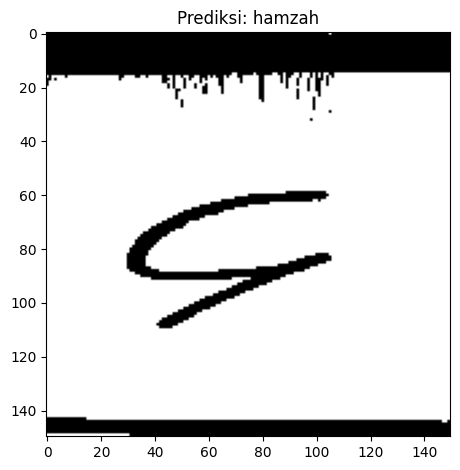

[[6.47977293e-01 2.76081892e-07 2.68026761e-05 1.19598035e-03
  2.01185629e-01 5.82376051e-05 1.53100787e-04 2.44707379e-11
  2.21463089e+01 1.10071480e-04 4.29771471e+00 5.04102173e+01
  1.00550759e+00 8.36952939e-04 1.89372673e+01 1.20386062e-06
  1.25837021e-08 1.50023222e-01 9.21389017e-07 6.57449220e-07
  3.86430123e-08 3.27989198e-07 5.43717155e-12 2.19151914e-07
  1.89138914e-03 2.68106343e-10 1.21849116e-05 1.28808635e-04
  2.19938469e+00 1.00188816e-10]]


In [133]:
# load data uj
img_path = r"C:\Users\Rzl\Downloads\hamzah3.jpeg"
new_image = load_image(img_path)

# prediksi
pred = loaded_model.predict(new_image)
pred *= 100
print(np.argmax(pred))

img = load_img(img_path, target_size=(160, 160))
plt.imshow(new_image.squeeze())
plt.title("Prediksi: {}".format(class_names[np.argmax(pred)]))
plt.tight_layout()
plt.show()
print(pred)

Nama huruf:  hamzah


11


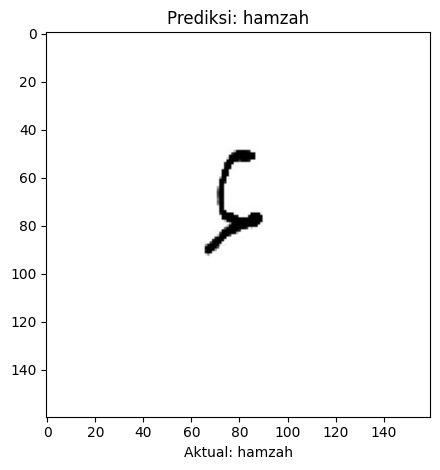

[[6.8162805e-08 3.5912773e-08 1.6615578e-03 8.3889763e-06 7.6072562e-09
  1.7497079e-08 3.5234347e-08 3.0156336e-08 2.9098568e-09 3.8477683e-07
  2.7211382e-07 9.9998283e+01 1.2369770e-07 7.1212135e-08 3.4811058e-07
  6.3308607e-09 2.3155748e-07 5.3688058e-08 4.2983970e-06 6.2092989e-09
  2.1388993e-05 1.4568906e-06 2.0316451e-08 5.0738889e-09 1.3055499e-06
  1.2394533e-05 1.0547537e-08 1.2132386e-08 1.6271741e-06 3.7360898e-08]]


In [127]:
# load data uji
huruf = input("Nama huruf: ")
img_path = 'dataset/' + VAL_DATA + '/' + huruf + '/'+ huruf + '_7.jpg'
new_image = load_image(img_path)

# prediksi
pred = loaded_model.predict(new_image)
pred *= 100
print(np.argmax(pred))

img = load_img(img_path, target_size=(160, 160))
plt.imshow(img)
plt.title("Prediksi: {}".format(class_names[np.argmax(pred)]))
plt.xlabel("Aktual: " + img_path.split("/")[2])
plt.tight_layout()
plt.show()
print(pred)

In [14]:
# Pengujian GUI

from ipywidgets import *
from IPython.display import clear_output, display
from tkinter import Tk, filedialog

def select_files(file):
    clear_output()
    root = Tk()
    root.withdraw() # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
    file.files = filedialog.askopenfilename(multiple=True) # List of selected files will be set button's file attribute.
    print(file.files) # Print the list of files selected.

ModuleNotFoundError: No module named 'ipywidgets'

In [41]:
fileselect = Button(description="File select")
fileselect.on_click(select_files)

display(fileselect)

('H:/Ngoding Python/Skripsi/Hijaiyah Deployment CNN/dataset/test_mixed/ain/ain_2.jpg',)


0


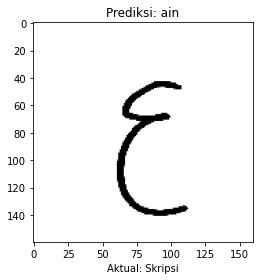

[[9.9989906e+01 1.3855977e-21 2.5522734e-18 4.1006083e-12 8.1949654e-16
  7.4127910e-19 8.8806365e-15 1.7906005e-15 8.8522956e-03 3.5717522e-09
  1.0736453e-03 1.7444733e-04 5.7614985e-10 2.5186303e-14 8.0932455e-10
  1.4593145e-19 3.7247591e-10 7.2022268e-09 2.0979016e-22 3.0006535e-19
  9.7600058e-18 7.5776700e-09 3.7494465e-12 4.9234932e-22 5.4810099e-26
  1.0877632e-06 7.6321688e-31 6.6209097e-08 1.6079262e-09 1.2132027e-25]]


In [43]:
# Don't run this cell if the cell above hadn't run yet

files = fileselect.files
img_path = files[0]
new_image = load_image(img_path)

# prediksi
pred = loaded_model.predict(new_image)
pred *= 100
print(np.argmax(pred))

img = load_img(img_path, target_size=(160, 160))
plt.imshow(img)
plt.title("Prediksi: {}".format(class_names[np.argmax(pred)]))
plt.xlabel("Aktual: " + img_path.split("/")[2])
plt.tight_layout()
plt.show()
print(pred)

In [11]:
# Menghitung akurasi secara manual
total = 0
betul = 0
for folder in class_names:
    for count, filename in enumerate(os.listdir(os.path.join(VALIDATION_DIR, folder))):
        img_path = 'dataset/' + VAL_DATA + '/' + folder + '/'+ filename
        new_image = load_image(img_path)
        pred = loaded_model.predict(new_image)
        if class_names[np.argmax(pred)] == folder:
            betul += 1
        total += 1

print("Akurasi pada data tes: {}%".format((betul/total)*100))

Akurasi pada data tes: 99.76190476190476%


## Confusion Matrix

In [12]:
# Confusion Matrix dan Classification Report
Y_pred = []

for folder in class_names:
    for labels, filename in enumerate(os.listdir(os.path.join(VALIDATION_DIR, folder))):
        img_path = 'dataset/' + VAL_DATA + '/' + folder + '/'+ filename
        new_image = load_image(img_path)
        pred = loaded_model.predict(new_image)
        Y_pred.append(np.argmax(pred, axis=1))

In [13]:
# Menampilkan hasil
print('\n=======================Confusion Matrix=======================\n')
print(confusion_matrix(validation_generator.classes, Y_pred))
print('\n\n=================Classification Report=================\n')
target_names = class_names
print(classification_report(validation_generator.classes, Y_pred, target_names=target_names))


=======================Confusion Matrix=======================

[[14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  